title: UX evaluation of the signup flow
author: Fabio Schmidt-Fischbach    
date: 2020-05-01
region: EU
summary: We lose 65% of customers between sign up initiated to sign up completed. We also already know on which screens people drop off. This report Looks at 1.1M> sign up journeys from the last months and try and understand what keeps users from dropping off.
link: https://docs.google.com/presentation/d/1QNwpFudfXwacyZYAuLw4fJ60DygXrGmtLkfFeubhDnU/edit?usp=sharing
tags: acquire, signup, UX

In [ ]:
query1 = """

with sample as ( 

select *, max(created) over(partition by domain_userid) as last_event
from dbt.zrh_upper_funnel 
where created between '2020-01-01' and '2020-03-01'

)

select *, 
		created::date as created_day, 
		case when last_event = created and step != 'email-confirmation' then 1 else 0 end as last_event_dummy
from sample 


)

"""


query2 = """

select domain_userid, 
		derived_tstamp::date , 
		JSON_EXTRACT_PATH_TEXT(ec.se_label, 'step') as step,
		JSON_EXTRACT_PATH_TEXT(ec.se_label, 'fieldName') as field, 
		JSON_EXTRACT_PATH_TEXT(ec.se_label, 'fieldIndex') as field_index, 
		ec.event_type, 
		count(1) 
      from ksp_event_crab as ec 
    inner join ksp_web_crab as wc using (event_id) 
    inner join ksp_event_types as et on ec.event_type = et.event_type 
    where se_action in ('registration.field_filled', 'registration.field_errored') and derived_tstamp between '2020-01-01' and '2020-03-01'
  group by 1,2,3,4,5,6
"""

third_query = """
        
with all_events as ( 
    select  domain_userid, 
            derived_tstamp, 
            JSON_EXTRACT_PATH_TEXT(ec.se_label, 'step') as step,
            JSON_EXTRACT_PATH_TEXT(ec.se_label, 'fieldName') as field, 
            lag(derived_tstamp) over(partition by domain_userid order by derived_tstamp rows unbounded preceding) as last_finish,
            datediff(seconds, last_finish, derived_tstamp ) as delta_seconds
    from ksp_event_crab as ec 
    inner join ksp_web_crab as wc using (event_id) 
    inner join ksp_event_types as et on ec.event_type = et.event_type 
    where se_action in ('registration.field_filled', 'registration.field_errored') and derived_tstamp between '2020-01-01' and '2020-03-01'
)

select  domain_userid, 
        derived_tstamp::date, 
        step, 
        field, 
        avg(delta_seconds)
from all_events
group by 1,2,3,4


"""

In [1]:
import pandas as pd
import numpy as np

In [1]:
sample = pd.read_csv("ui_sample.csv")

NameError: name 'pd' is not defined

In [8]:
ui.columns.values

array(['domain_userid', 'derived_tstamp', 'step', 'field', 'field_error',
       'field_filled'], dtype=object)

In [1]:
# load data and create final dataset.
import pandas as pd
import numpy as np

sample = pd.read_csv("ui_sample.csv")

ui = pd.read_csv("ui_errors.csv")

# pivot ui
ui.loc[ui["event_type"] == 631, "event_type"] = "field_filled"
ui.loc[ui["event_type"] == 632, "event_type"] = "field_error"

# we pivot this to wide to make sure we dont miss out on 0s for users: the fill na is the crucial bit of this code.
ui = (
    pd.pivot_table(
        data=ui,
        index=["domain_userid", "derived_tstamp"],
        columns=["step", "field", "event_type"],
        values="count",
        aggfunc=np.sum,
    )
    .reset_index()
    .fillna(0)
)
# make it long again
ui = pd.melt(ui, id_vars=["domain_userid", "derived_tstamp"])
# make it wide again.
ui = (
    pd.pivot_table(
        data=ui,
        index=["domain_userid", "derived_tstamp", "step", "field"],
        columns=["event_type"],
        values="value",
    )
    .reset_index()
    .fillna(0)
)

print(ui.shape)
print(sample.shape)
final = pd.merge(
    sample,
    ui,
    left_on=["domain_userid", "created_day", "step"],
    right_on=["domain_userid", "derived_tstamp", "step"],
    how="left",
).fillna(0)

final["never_finish"] = final.groupby("domain_userid")["last_event_dummy"].transform(
    "max"
)
final["finish"] = 1
final.loc[final["never_finish"] == 1, "finish"] = 0

# remove missing to zero
final.loc[final["field_filled"].isna() == True, "field_filled"] = 0
final.loc[final["field_error"].isna() == True, "field_error"] = 0

# categorize none-once-UX error
final["filled_cat"] = "None"
final.loc[final["field_filled"] == 1, "filled_cat"] = "Once"
final.loc[final["field_filled"] > 1, "filled_cat"] = "More than once"

# categorize none-once-UX error
final["error_cat"] = "None"
final.loc[final["field_error"] > 0, "error_cat"] = "Error"

# read time spent on field
time = pd.read_csv("ui_time.csv")
# merge it to master.
final = pd.merge(
    final,
    time,
    left_on=["domain_userid", "created_day", "step", "field"],
    right_on=["domain_userid", "derived_tstamp", "step", "field"],
    how="left",
).fillna(0)


final.to_pickle("ui_final.pkl")
print("Exported")

(87572232, 6)
(6155906, 13)
Exported


In [1]:
import pandas as pd

final = pd.read_pickle("ui_final.pkl")


final.groupby("step")["domain_userid"].nunique()

step
additional-information        300885
additional-information-it         13
address                       468894
address-confirmation          444124
create-account                406328
create-password                 5792
email-confirmation            381391
first-bank-account             52475
fraud-prevention               23390
legal-address                     14
legal-questions               115278
legal-questions-it                 1
personal-information          798981
phone-number                  504722
promo-code                    413743
signup-start                 1090551
social-security-number         72709
tax-information               325177
us-citizenship                325689
us-tax-liability              321677
Name: domain_userid, dtype: int64

# Analysis

In [2]:
final = pd.read_pickle("ui_final.pkl")

NameError: name 'pd' is not defined

In [26]:
# how man customers do we have

len(final["domain_userid"].unique())

1145779

## Fields filled.

# Personal information

In [20]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "personal-information")
    & (
        final["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
                "middleName",
            ]
        )
    ),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat"]]
    .groupby(["field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled in ")),
    color="filled_cat:N",
).properties(title="% of users that filled in", width=400)

alt.Chart(...)

In [21]:
d = final.loc[
    (final["step"] == "personal-information")
    & (
        final["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
                "middleName",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "last_screen_for_user", "filled_cat"]]
    .groupby(["field", "last_screen_for_user", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]


alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled")),
    column="last_screen_for_user:N",
    color="filled_cat:N",
).properties(title="% of users that filled in ", width=400)

alt.Chart(...)

In [ ]:
import altair as alt

d = final.loc[
    (final["last_event_dummy"] == 1)
    & (final["step"] == "personal-information")
    & (
        final["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = d.groupby(["domain_userid", "field"]).agg("sum").reset_index()

d["filled_cat"] = 0
d.loc[d["field_filled"] > 0, "filled_cat"] = 1

d = (
    d.loc[:, ["domain_userid", "filled_cat"]]
    .groupby(["domain_userid"])["filled_cat"]
    .agg("sum")
    .reset_index()
)

d = d.groupby("filled_cat")["domain_userid"].nunique().reset_index()

d["group"] = 1
d["total"] = d.groupby("group")["domain_userid"].transform("sum")

d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X(
        "filled_cat:N",
        axis=alt.Axis(title="Number of fields filled on personal information screen"),
    ),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of customers who fail on this screen")),
).properties(
    width=400,
    title="How many fields do customers that do not proceed to the next step fill in?",
)

In [ ]:
# now look at errors.

In [2]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "personal-information")
    & (
        final["field"].isin(
            ["birthDate", "email", "firstName", "lastName", "middleName"]
        )
    ),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d["error_cat"] = "No error"
d.loc[d["field_error"] > 0, "error_cat"] = "Error"

d = (
    d.loc[:, ["domain_userid", "field", "error_cat", "last_screen_for_user"]]
    .groupby(["field", "last_screen_for_user", "error_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["last_screen_for_user", "field"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]

import altair as alt

alt.Chart(d.loc[d["error_cat"] == "Error", :]).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% with error")),
    column="last_screen_for_user:N",
).properties(title="% of users with error", width=400)

alt.Chart(...)

In [2]:
import seaborn as sns
import pandas as pd
import altair as alt

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "personal-information")
    & (
        final["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
                "middleName",
            ]
        )
    ),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})


d = (
    d.loc[:, ["domain_userid", "field", "avg", "last_screen_for_user"]]
    .groupby(["field", "last_screen_for_user", "avg"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["last_screen_for_user", "field"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]

# sns.catplot(x='avg',y='perc', col='field', hue='last_screen_for_user', kind='bar', data=d)

d.head()

,field,last_screen_for_user,avg,domain_userid,total,perc
0,birthDateDay,0,0.0,10731,495361,2.166299
1,birthDateDay,0,1.0,114281,495361,23.070246
2,birthDateDay,0,2.0,142979,495361,28.863596
3,birthDateDay,0,3.0,84680,495361,17.094604
4,birthDateDay,0,4.0,55294,495361,11.162364


In [14]:
# sns.catplot(x='avg',y='perc', col='field', hue='last_screen_for_user', kind='bar', data=d)

alt.Chart(d.loc[(d["avg"] < 15) & (d["field"] != "middleName"), :]).mark_line().encode(
    x="avg:Q",
    y="perc:Q",
    color="last_screen_for_user:N",
).facet(facet="field:N", columns=2)

alt.FacetChart(...)

In [3]:
import pandas as pd

final = pd.read_pickle("ui_final.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'ui_final.pkl'

# Phone numbers

In [23]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "phone-number")
    & (final["field"].isin(["phone", "phoneCountryCode"])),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat"]]
    .groupby(["field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled in ")),
    color="filled_cat:N",
).properties(title="% of users that filled in", width=400)

alt.Chart(...)

In [5]:
import seaborn as sns
import pandas as pd
import altair as alt

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "phone-number")
    & (final["field"].isin(["phone", "phoneCountryCode"])),
    :,
]

d = d.groupby(["domain_userid", "field"])["field_filled"].agg("sum").reset_index()

d = d.groupby(["field_filled", "field"])["domain_userid"].agg("nunique").reset_index()

d["perc"] = (
    100 * d["domain_userid"] / d.groupby("field")["domain_userid"].transform("sum")
)

d["percentile"] = d.groupby("field")["perc"].cumsum()

alt.Chart(...)

In [6]:
alt.Chart(d.loc[d["field_filled"] < 20, :]).mark_line().encode(
    x="field_filled:Q", y="percentile:Q", color="field:N"
)

alt.Chart(...)

In [22]:
d = final.loc[
    (final["step"] == "phone-number")
    & (final["field"].isin(["phone", "phoneCountryCode"])),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "last_screen_for_user", "filled_cat"]]
    .groupby(["field", "last_screen_for_user", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]


alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
    column="last_screen_for_user:N",
    color="filled_cat:N",
).properties(title="% of users that filled field", width=400)

alt.Chart(...)

In [24]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "phone-number")
    & (final["field"].isin(["phone", "phoneCountryCode"])),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = (
    d.loc[:, ["domain_userid", "field", "error_cat"]]
    .groupby(["field", "error_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled in ")),
    color="error_cat:N",
).properties(title="% of users with error", width=400)

alt.Chart(...)

In [30]:
d = final.loc[
    (final["step"] == "phone-number")
    & (final["field"].isin(["phone", "phoneCountryCode"])),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["error_cat"] = "No error"
d.loc[d["field_error"] > 0, "error_cat"] = "Error"

d = (
    d.loc[:, ["domain_userid", "field", "last_screen_for_user", "error_cat"]]
    .groupby(["field", "last_screen_for_user", "error_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]


alt.Chart(d.loc[d["error_cat"] == "Error", :]).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
    column="last_screen_for_user:N",
).properties(title="% of users that have error", width=400)

alt.Chart(...)

In [31]:
alt.Chart(d.loc[d["error_cat"] == "Error", :]).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
    column="last_screen_for_user:N",
).properties(title="% of users that have error", width=400)

alt.Chart(...)

# Address

In [36]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "oneLineAddress",
                "shippingAddress",
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat"]]
    .groupby(["field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled in ")),
    color="filled_cat:N",
).properties(title="% of users that filled in", width=400)

alt.Chart(...)

In [37]:
d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "oneLineAddress",
                "shippingAddress",
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "last_screen_for_user", "filled_cat"]]
    .groupby(["field", "last_screen_for_user", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]


alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
    column="last_screen_for_user:N",
    color="filled_cat:N",
).properties(title="% of users that filled field", width=400)

alt.Chart(...)

In [ ]:
d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "oneLineAddress",
                "shippingAddress",
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "last_screen_for_user", "filled_cat"]]
    .groupby(["field", "last_screen_for_user", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]


alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
    column="last_screen_for_user:N",
    color="filled_cat:N",
).properties(title="% of users that filled field", width=400)

# Create account 

In [40]:
d = final.loc[
    (final["step"] == "create-account")
    & (
        final["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat"]]
    .groupby(["field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled in ")),
    color="filled_cat:N",
).properties(title="% of users that filled in", width=400)

alt.Chart(...)

In [41]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "create-account")
    & (
        final["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]

d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = (
    d.loc[:, ["domain_userid", "field", "error_cat"]]
    .groupby(["field", "error_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% filled in ")),
    color="error_cat:N",
).properties(title="% of users with error", width=400)

alt.Chart(...)

In [39]:
d = final.loc[
    (final["step"] == "create-account")
    & (
        final["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "last_screen_for_user", "filled_cat"]]
    .groupby(["field", "last_screen_for_user", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]


alt.Chart(d).mark_bar().encode(
    x=alt.X("field:N", axis=alt.Axis(title="Field")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
    column="last_screen_for_user:N",
    color="filled_cat:N",
).properties(title="% of users that filled field", width=400)

alt.Chart(...)

In [4]:
import altair as alt

d = final.loc[
    (final["last_event_dummy"] == 1)
    & (final["step"] == "personal-information")
    & (
        final["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

d = d.groupby(["domain_userid", "field"]).agg("sum").reset_index()

d["filled_cat"] = 0
d.loc[d["field_filled"] > 0, "filled_cat"] = 1

d = (
    d.loc[:, ["domain_userid", "filled_cat"]]
    .groupby(["domain_userid"])["filled_cat"]
    .agg("sum")
    .reset_index()
)

d = d.groupby("filled_cat")["domain_userid"].nunique().reset_index()

d["group"] = 1
d["total"] = d.groupby("group")["domain_userid"].transform("sum")

d["perc"] = 100 * d["domain_userid"] / d["total"]

alt.Chart(d).mark_bar().encode(
    x=alt.X(
        "filled_cat:N",
        axis=alt.Axis(title="Number of fields filled on personal information screen"),
    ),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of customers who fail on this screen")),
).properties(
    width=400,
    title="How many fields do customers that do not proceed to the next step fill in?",
)

alt.Chart(...)

In [4]:
final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "oneLineAddress",
                "shippingAddress",
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]

FileNotFoundError: [Errno 2] No such file or directory: 'ui_final.pkl'

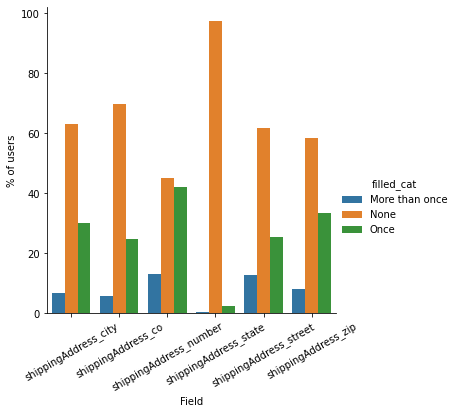

In [35]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = d.groupby(["domain_userid", "field"]).agg("sum").reset_index()

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat"]]
    .groupby(["field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

ax = sns.catplot(x="field", y="perc", hue="filled_cat", kind="bar", data=d)
ax.set(xlabel="Field", ylabel="% of users")
ax.set_xticklabels(rotation=30)

ax

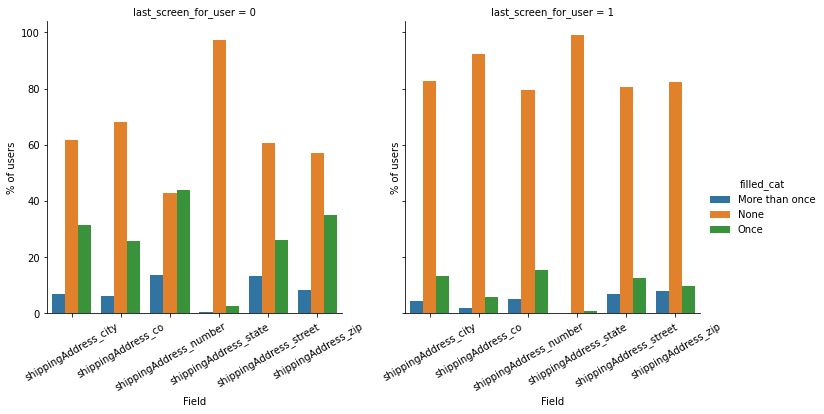

In [45]:
d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat", "last_screen_for_user"]]
    .groupby(["last_screen_for_user", "field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]

ax = sns.catplot(
    x="field",
    y="perc",
    hue="filled_cat",
    col="last_screen_for_user",
    kind="bar",
    data=d,
)
ax.set(xlabel="Field", ylabel="% of users")
ax.set_xticklabels(rotation=30)

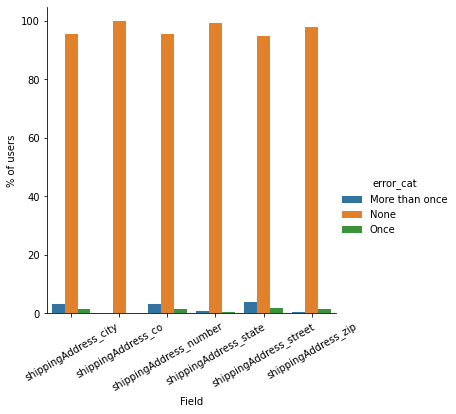

In [39]:
import seaborn as sns

final = pd.read_pickle("ui_final.pkl")

d = final.loc[
    (final["step"] == "address")
    & (
        final["field"].isin(
            [
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = d.groupby(["domain_userid", "field"]).agg("sum").reset_index()

d["error_cat"] = "None"
d.loc[d["field_error"] == 1, "error_cat"] = "Once"
d.loc[d["field_error"] > 1, "error_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "error_cat"]]
    .groupby(["field", "error_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

ax = sns.catplot(x="field", y="perc", hue="error_cat", kind="bar", data=d)
ax.set(xlabel="Field", ylabel="% of users")
ax.set_xticklabels(rotation=30)

ax

In [33]:
import altair as alt

d = final.loc[final["field"] == "oneLineAddress", :]

d["week"] = pd.to_datetime(d["created"]).dt.week
d = d.groupby("created_day")["domain_userid"].nunique().reset_index()

alt.Chart(d).mark_line().encode(x="created_day:T", y="domain_userid:Q")

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


alt.Chart(...)

In [30]:
d.head(100)

,week,domain_userid
0,1,31121
1,2,78141
2,3,89367
3,4,90474
4,5,92416
5,6,88815
6,7,84016
7,8,78218
8,9,67853


In [31]:
import altair as alt

d = final.loc[final["field"] == "shippingAddress_co", :]

d["week"] = pd.to_datetime(d["created"]).dt.week
d = d.groupby("week")["domain_userid"].nunique().reset_index()

alt.Chart(d).mark_line().encode(x="week:T", y="domain_userid:Q")

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


alt.Chart(...)

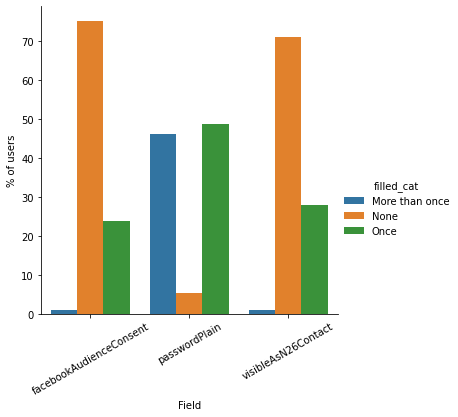

In [12]:
d = final.loc[
    (final["step"] == "create-account")
    & (
        final["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = d.groupby(["domain_userid", "field"]).agg("sum").reset_index()

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat"]]
    .groupby(["field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

ax = sns.catplot(x="field", y="perc", hue="filled_cat", kind="bar", data=d)
ax.set(xlabel="Field", ylabel="% of users")
ax.set_xticklabels(rotation=30)

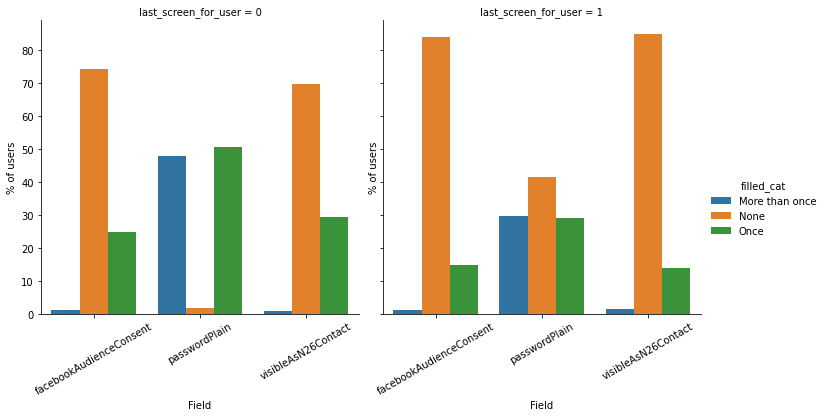

In [44]:
d = final.loc[
    (final["step"] == "create-account")
    & (
        final["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = (
    d.groupby(["domain_userid", "field", "last_screen_for_user"])
    .agg("sum")
    .reset_index()
)

d["filled_cat"] = "None"
d.loc[d["field_filled"] == 1, "filled_cat"] = "Once"
d.loc[d["field_filled"] > 1, "filled_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "filled_cat", "last_screen_for_user"]]
    .groupby(["last_screen_for_user", "field", "filled_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field", "last_screen_for_user"])["domain_userid"].transform(
    "sum"
)
d["perc"] = 100 * d["domain_userid"] / d["total"]

ax = sns.catplot(
    x="field",
    y="perc",
    hue="filled_cat",
    col="last_screen_for_user",
    kind="bar",
    data=d,
)
ax.set(xlabel="Field", ylabel="% of users")
ax.set_xticklabels(rotation=30)

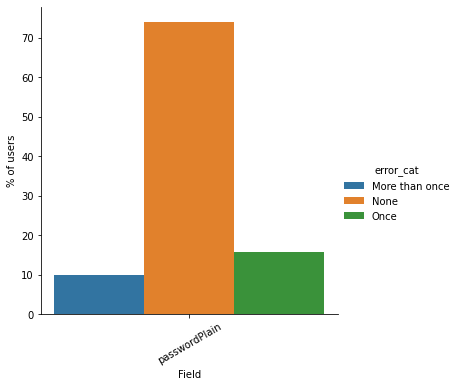

In [42]:
import seaborn as sns

d = final.loc[
    (final["step"] == "create-account") & (final["field"].isin(["passwordPlain"])), :
]
d = d.rename(columns={"last_event_dummy": "last_screen_for_user"})

# aggregate
d = d.groupby(["domain_userid", "field"]).agg("sum").reset_index()

d["error_cat"] = "None"
d.loc[d["field_error"] == 1, "error_cat"] = "Once"
d.loc[d["field_error"] > 1, "error_cat"] = "More than once"

d = (
    d.loc[:, ["domain_userid", "field", "error_cat"]]
    .groupby(["field", "error_cat"])["domain_userid"]
    .nunique()
    .reset_index()
)

d["total"] = d.groupby(["field"])["domain_userid"].transform("sum")
d["perc"] = 100 * d["domain_userid"] / d["total"]

ax = sns.catplot(x="field", y="perc", hue="error_cat", kind="bar", data=d)
ax.set(xlabel="Field", ylabel="% of users")
ax.set_xticklabels(rotation=30)

ax

In [41]:
d.head()

,field,error_cat,domain_userid,total,perc
0,facebookAudienceConsent,None,406191,406191,100.000000
1,passwordPlain,More than once,40963,406191,10.084665
2,passwordPlain,None,301260,406191,74.167079
3,passwordPlain,Once,63968,406191,15.748256
4,visibleAsN26Contact,None,406191,406191,100.000000


In [56]:
d = data.loc[
    (data["field_filled"] > 0)
    & (data["field_filled"] < 10)
    & (data["step"] == "personal-information")
    & (
        data["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
                "middleName",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X(
        "field_filled:Q", axis=alt.Axis(title="Number of times a field was filled")
    ),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [5]:
# look at personal information screen in detail for those that dont finish it.


final = pd.read_pickle("ui_final.pkl")

final = final.loc[
    (final["step"] == "personal-information") & (final["last_event_dummy"] == 1), :
]
final = final.loc[
    final["field"].isin(
        [
            "birthDateDay",
            "birthDateMonth",
            "birthDateYear",
            "email",
            "firstName",
            "lastName",
            "middleName",
        ]
    ),
    :,
]

FileNotFoundError: [Errno 2] No such file or directory: 'ui_final.pkl'

In [59]:
d = data.loc[
    (data["field_filled"] > 0)
    & (data["field_filled"] < 10)
    & (data["step"] == "address")
    & (
        data["field"].isin(
            [
                "shippingAddress",
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X(
        "field_filled:Q", axis=alt.Axis(title="Number of times a field was filled")
    ),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [60]:
d = data.loc[
    (data["field_filled"] > 0)
    & (data["field_filled"] < 10)
    & (data["step"] == "personal-information")
    & (
        data["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
                "middleName",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X(
        "field_filled:Q", axis=alt.Axis(title="Number of times a field was filled")
    ),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [62]:
d = data.loc[
    (data["field_filled"] > 0)
    & (data["field_filled"] < 10)
    & (data["step"] == "additional-information")
    & (
        data["field"].isin(
            ["birthCountryName", "nationalityCountryName", "birthPlace", "gender"]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X(
        "field_filled:Q", axis=alt.Axis(title="Number of times a field was filled")
    ),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [63]:
d = data.loc[
    (data["field_filled"] > 0)
    & (data["field_filled"] < 10)
    & (data["step"] == "additional-information")
    & (
        data["field"].isin(
            [
                "birthCountryName",
                "nationalityCountryName",
                "birthPlace",
                "gender",
                "taxNumbers",
                "hasUSCitizenship",
                "taxCountryCodes",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X(
        "field_filled:Q", axis=alt.Axis(title="Number of times a field was filled")
    ),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [65]:
d = data.loc[
    (data["field_filled"] > 0)
    & (data["field_filled"] < 10)
    & (data["step"] == "create-account")
    & (
        data["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X(
        "field_filled:Q", axis=alt.Axis(title="Number of times a field was filled")
    ),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [61]:
data["field"].unique()

array(['accountUsage', 'bankAccountCountry', 'bankAccountCountryName',
       'birthCountryName', 'birthDate', 'birthDateDay', 'birthDateMonth',
       'birthDateYear', 'birthPlace', 'email', 'facebookAudienceConsent',
       'firstName', 'fiscalCode', 'gender', 'hasTemporaryAddress',
       'hasUSCitizenship', 'incomeSource', 'isFirstBankAccount',
       'isPoliticallyExposedPerson', 'isUSTaxLiable', 'lastName',
       'legalAddress_city', 'legalAddress_co', 'legalAddress_number',
       'legalAddress_street', 'legalAddress_zip', 'middleName',
       'nationalIdentificationNumber', 'nationalityCountryName',
       'newsletter', 'occupation', 'oneLineAddress', 'passwordPlain',
       'phone', 'phoneCountryCode', 'privacyCRIF', 'privacyPolicy',
       'promoCode', 'residencyCountryName', 'shippingAddress',
       'shippingAddress.blacklisted', 'shippingAddress_city',
       'shippingAddress_co', 'shippingAddress_number',
       'shippingAddress_state', 'shippingAddress_street',
       '

In [66]:
final = pd.read_pickle("ui_final.pkl")


# for each user look at how often they filled/errored on that field.
data = (
    final.groupby(["step", "field", "domain_userid"])
    .agg({"field_filled": "sum", "field_error": "sum"})
    .reset_index()
)

data["count"] = 1

data = data.groupby(["field", "step", "field_error"]).agg("sum").reset_index()

data["total"] = data.groupby(["field", "step"])["count"].transform("sum")
data["perc"] = 100 * data["count"] / data["total"]


data["cum"] = data.groupby(["field", "step"])["perc"].cumsum()

In [69]:
d = data.loc[
    (data["field_error"] < 10)
    & (data["step"] == "address")
    & (
        data["field"].isin(
            [
                "shippingAddress",
                "shippingAddress_city",
                "shippingAddress_co",
                "shippingAddress_number",
                "shippingAddress_state",
                "shippingAddress_street",
                "shippingAddress_zip",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X("field_error:Q", axis=alt.Axis(title="Number of errors")),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [71]:
d = data.loc[
    (data["field_error"] < 10)
    & (data["step"] == "phone-number")
    & (data["field"].isin(["phone", "phoneCountryCode"])),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X("field_error:Q", axis=alt.Axis(title="Number of errors")),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [70]:
d = data.loc[
    (data["field_error"] < 10)
    & (data["step"] == "personal-information")
    & (
        data["field"].isin(
            [
                "birthDateDay",
                "birthDateMonth",
                "birthDateYear",
                "email",
                "firstName",
                "lastName",
                "middleName",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X("field_error:Q", axis=alt.Axis(title="Number of errors")),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [72]:
d = data.loc[
    (data["field_error"] < 10)
    & (data["step"] == "additional-information")
    & (
        data["field"].isin(
            ["birthCountryName", "nationalityCountryName", "birthPlace", "gender"]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X("field_error:Q", axis=alt.Axis(title="Number of errors")),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

In [73]:
d = data.loc[
    (data["field_error"] < 10)
    & (data["step"] == "create-account")
    & (
        data["field"].isin(
            [
                "passwordPlain",
                "visibleAsN26Contact",
                "facebookAudienceConsent",
            ]
        )
    ),
    :,
]

alt.Chart(d).mark_line().encode(
    x=alt.X("field_error:Q", axis=alt.Axis(title="Number of errors")),
    y=alt.Y("cum:Q", axis=alt.Axis(title="% of users")),
    color="field",
    column="step",
)

alt.Chart(...)

# Impact analysis

In [115]:
import seaborn as sns
import matplotlib as plt

final = pd.read_pickle("ui_final.pkl")
final["finish_next"] = 1
final.loc[final["last_event_dummy"] == 1, "finish_next"] = 0

# for each user look at how often they filled/errored on that field.
data = (
    final.groupby(["step", "field", "domain_userid"])
    .agg({"field_filled": "sum", "field_error": "sum", "finish": "max"})
    .reset_index()
)

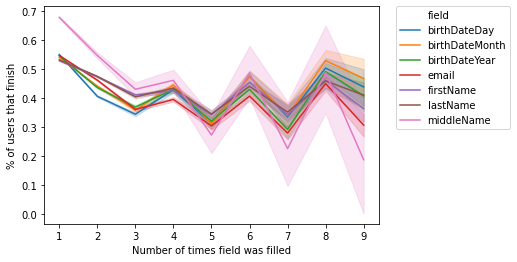

In [112]:
ax = sns.lineplot(
    x="field_filled",
    y="finish",
    hue="field",
    data=data.loc[
        (data["field_filled"] > 0)
        & (data["field_filled"] < 10)
        & (data["step"] == "personal-information")
        & (
            data["field"].isin(
                [
                    "birthDateDay",
                    "birthDateMonth",
                    "birthDateYear",
                    "email",
                    "firstName",
                    "lastName",
                    "middleName",
                ]
            )
        ),
        :,
    ],
)
ax.set(xlabel="Number of times field was filled", ylabel="% of users that finish")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

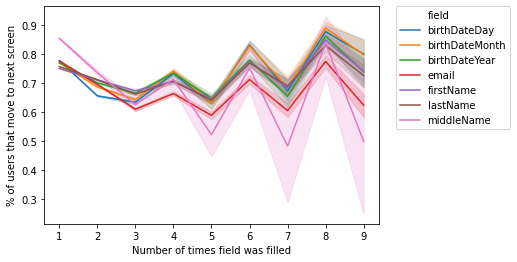

In [116]:
data = (
    final.groupby(["step", "field", "domain_userid"])
    .agg({"field_filled": "sum", "field_error": "sum", "finish_next": "max"})
    .reset_index()
)

ax = sns.lineplot(
    x="field_filled",
    y="finish_next",
    hue="field",
    data=data.loc[
        (data["field_filled"] > 0)
        & (data["field_filled"] < 10)
        & (data["step"] == "personal-information")
        & (
            data["field"].isin(
                [
                    "birthDateDay",
                    "birthDateMonth",
                    "birthDateYear",
                    "email",
                    "firstName",
                    "lastName",
                    "middleName",
                ]
            )
        ),
        :,
    ],
)
ax.set(
    xlabel="Number of times field was filled",
    ylabel="% of users that move to next screen",
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Estimation

In [6]:
import seaborn as sns
import matplotlib as plt

final = pd.read_pickle("ui_final.pkl")
final["finish_next"] = 1
final.loc[final["last_event_dummy"] == 1, "finish_next"] = 0

# features differ depending on the step
address = [
    "shippingAddress",
    "shippingAddress_city",
    "shippingAddress_co",
    "shippingAddress_number",
    "shippingAddress_state",
    "shippingAddress_street",
    "shippingAddress_zip",
]
personal = [
    "birthDateDay",
    "birthDateMonth",
    "birthDateYear",
    "email",
    "firstName",
    "lastName",
    "middleName",
]
phone = ["phone", "phoneCountryCode"]
additional = ["birthCountryName", "nationalityCountryName", "birthPlace", "gender"]
create = ["passwordPlain", "visibleAsN26Contact", "facebookAudienceConsent"]

# list of steps we estimate separetely.
steps = [
    "personal-information",
    "phone-number",
    "address",
    "address-confirmation",
    "additional-information",
    "create-account",
]

FileNotFoundError: [Errno 2] No such file or directory: 'ui_final.pkl'

In [214]:
# define function to estimate
from sklearn.linear_model import LogisticRegression


def prepare_data(data, step, features):
    """Prepare data for estimation."""
    data = data.loc[(data["step"] == step) & (data["field"].isin(features) == True), :]

    # aggregate to one obs per user.
    data = (
        data.groupby(["domain_userid", "field"])
        .agg({"field_filled": "sum", "finish_next": "max"})
        .reset_index()
    )

    # re-configure data: it's either > 1 --> UX problem or 0 no UX problem (possibly, not filled in at all)
    data["ux_error"] = 0
    data.loc[data["field_filled"] > 1, "ux_error"] = 1

    # pivot data frame to be wide.
    data = data.pivot_table(
        index=["domain_userid", "finish_next"], columns="field", values="ux_error"
    ).reset_index()

    y = data["finish_next"]
    # everything but user id and outcome is a feature
    features = (
        pd.Series(data.columns.values).isin(["domain_userid", "finish_next"]) == False
    )
    X = data.loc[:, data.columns.values[features]].fillna(0)
    return (y, X)


def estimate_model(y, X):
    """Estimate penalized probit model."""
    log_model = LogisticRegression(random_state=0).fit(X, y)

    # check probability of finishing without UX error.
    prediction = log_model.predict_proba(np.zeros(X.shape[1]).reshape(1, X.shape[1]))

    # coefficients
    coefs = log_model.coef_

    # predictions for all models
    predict_all = log_model.predict_proba(X)

    return (log_model, prediction, coefs, predict_all)


y, X = prepare_data(final, "personal-information", personal)

model, prediction, coefs, predict_all = estimate_model(y, X)

In [194]:
def evaluate_simulation(prediction, predict_all, step):
    """Compare average success rate with and without UX errors"""
    data = pd.DataFrame(predict_all, columns=["Fail", "Success"])
    data = pd.melt(data, value_vars=["Fail", "Success"])

    data = data.groupby("variable").agg("mean").reset_index()
    data["type"] = "Baseline"

    data = data.loc[data["variable"] == "Success", :]

    # get predicted data
    d = {"variable": ["Success"], "value": prediction[0][1], "type": "No UX errors"}
    d = pd.DataFrame.from_dict(d)

    # append the two dataframes

    data = data.append(d)

    data["value"] = data["value"] * 100

    chart = (
        alt.Chart(data)
        .mark_bar()
        .encode(
            x="type:N",
            y=alt.Y(
                "value:Q",
                axis=alt.Axis(title="% make it to next step"),
                scale=alt.Scale(domain=(70, 78)),
            ),
        )
        .properties(width=400, title=step)
    )
    return chart


evaluate_simulation(prediction, predict_all, "Personal information")

alt.Chart(...)

In [204]:
def display_coefs(coefs, X, step):
    """Show estimated coefficients as bar chart."""

    data = pd.DataFrame(coefs, columns=X.columns.values)

    data = data.melt()

    chart = (
        alt.Chart(data)
        .mark_bar()
        .encode(x="variable:N", y=alt.Y("value:Q", axis=alt.Axis(title="Coefficient")))
        .properties(width=400, title="Personal information")
    )
    return chart


display_coefs(coefs, X, "Personal information")

alt.Chart(...)

In [215]:
def do_all(data, step, features):
    y, x = prepare_data(data, step, features)
    model, prediction, coefs, predict_all = estimate_model(y, X)

    simulation = evaluate_simulation(prediction, predict_all, step)
    coefficients = display_coefs(coefs, X, step)

    return (simulation, coefficients)

In [209]:
sim, coef = do_all(final, steps[0], personal)

sim

AttributeError: module 'matplotlib' has no attribute 'show'

In [212]:
sim

alt.Chart(...)

In [216]:
sim, coef = do_all(final, steps[3], address)

sim

ValueError: Found input variables with inconsistent numbers of samples: [668667, 5]

In [ ]:
# features differ depending on the step
address = [
    "shippingAddress",
    "shippingAddress_city",
    "shippingAddress_co",
    "shippingAddress_number",
    "shippingAddress_state",
    "shippingAddress_street",
    "shippingAddress_zip",
]
personal = [
    "birthDateDay",
    "birthDateMonth",
    "birthDateYear",
    "email",
    "firstName",
    "lastName",
    "middleName",
]
phone = ["phone", "phoneCountryCode"]
additional = ["birthCountryName", "nationalityCountryName", "birthPlace", "gender"]
create = ["passwordPlain", "visibleAsN26Contact", "facebookAudienceConsent"]

# list of steps we estimate separetely.
steps = [
    "personal-information",
    "phone-number",
    "address",
    "address-confirmation",
    "additional-information",
    "create-account",
]

In [157]:
coefs

array([[-0.7563427 ,  0.28064712,  0.40779287, -0.38097463, -0.00898265,
         0.02893664,  0.00662573]])

In [149]:
np.zeros(X.shape[1])

array([0., 0., 0., 0., 0., 0., 0.])

In [142]:
s = pd.Series(X.columns.values).isin(["domain_userid", "finish_next"]) == False


X.columns.values[s]

array(['shippingAddress', 'shippingAddress_city', 'shippingAddress_co',
       'shippingAddress_number', 'shippingAddress_state',
       'shippingAddress_street', 'shippingAddress_zip'], dtype=object)

In [124]:
pd.Series(final.columns.values).isin(["domain_userid", "finish_next"]) == False

0     False
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18    False
dtype: bool